In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming your CSV is loaded into 'df'
# Step 1: Preprocessing

# Load the dataset
df = pd.read_csv(r"..\datasets\decade\sept-week12-4.csv")  # Replace with your file path

# Convert 'time' column to datetime format (if it's not already)
df['time'] = pd.to_datetime(df['time'])

# Select relevant columns for prediction
# Features: open, low, close, tick_volume, spread, real_volume
# Target: high (peak price)
features = df[['open', 'low', 'close', 'tick_volume', 'spread', 'real_volume']].values
target = df['high'].values.reshape(-1, 1)

# Step 2: Scale the features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Step 3: Create sequences for LSTM

# Optional: Visualization of the actual vs predicted peak prices


In [3]:
df["high-next"] = df["high"].shift(-1)
df

,Unnamed: 0,time,open,high,low,close,tick_volume,spread,real_volume,high-next
0,0,2022-01-03 00:00:00,1.13693,1.13778,1.13645,1.13728,1916,7,0,1.13759
1,1,2022-01-03 02:00:00,1.13728,1.13759,1.13497,1.13588,2403,0,0,1.13589
2,2,2022-01-03 04:00:00,1.13588,1.13589,1.13413,1.13482,1898,0,0,1.13490
3,3,2022-01-03 06:00:00,1.13483,1.13490,1.13360,1.13380,1327,0,0,1.13501
4,4,2022-01-03 08:00:00,1.13380,1.13501,1.13349,1.13480,2825,0,0,1.13567
...,...,...,...,...,...,...,...,...,...,...
8420,8420,2024-09-13 14:00:00,1.10904,1.10933,1.10792,1.10929,4420,3,0,1.11016
8421,8421,2024-09-13 16:00:00,1.10928,1.11016,1.10843,1.10888,6254,3,0,1.10917
8422,8422,2024-09-13 18:00:00,1.10890,1.10917,1.10768,1.10838,3949,3,0,1.10857
8423,8423,2024-09-13 20:00:00,1.10838,1.10857,1.10765,1.10780,2604,3,0,1.10812


In [4]:
df['open']

0       1.13693
1       1.13728
2       1.13588
3       1.13483
4       1.13380
         ...   
8420    1.10904
8421    1.10928
8422    1.10890
8423    1.10838
8424    1.10778
Name: open, Length: 8425, dtype: float64

In [5]:
def create_sequences(features, target, time_steps=60):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 60  # Example: 60 minutes (1 hour)
X, y = create_sequences(features_scaled, target_scaled, time_steps)

# Step 4: Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 5: Build the LSTM model with 10 layers



In [6]:
model = Sequential()

# First LSTM layer (return_sequences=True to stack more LSTM layers)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Add more LSTM layers
for _ in range(9):  # Add 9 more LSTM layers
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

# Final LSTM layer without return_sequences (last LSTM layer)
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer for peak price prediction
model.add(Dense(units=1))

# Step 6: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Predict on the test set
predicted_prices = model.predict(X_test)

# Step 9: Rescale the predicted and actual prices
predicted_prices_rescaled = scaler_target.inverse_transform(predicted_prices)
y_test_rescaled = scaler_target.inverse_transform(y_test)

# Step 10: Evaluate model performance
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

Epoch 1/20
210/210 [==============================] - 41s 110ms/step - loss: 0.0162 - val_loss: 0.0021
Epoch 2/20
210/210 [==============================] - 19s 93ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 3/20
210/210 [==============================] - 19s 92ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 4/20
210/210 [==============================] - 19s 91ms/step - loss: 0.0046 - val_loss: 7.7944e-04
Epoch 5/20
210/210 [==============================] - 19s 91ms/step - loss: 0.0040 - val_loss: 9.1701e-04
Epoch 6/20
210/210 [==============================] - 19s 91ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 7/20
210/210 [==============================] - 19s 91ms/step - loss: 0.0033 - val_loss: 4.6106e-04
Epoch 8/20
210/210 [==============================] - 19s 90ms/step - loss: 0.0029 - val_loss: 6.1822e-04
Epoch 9/20
210/210 [==============================] - 19s 91ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 10/20
210/210 [==============================] - 19s 92ms/s

In [7]:
pd.DataFrame(y_test_rescaled)[0]

0       1.08459
1       1.08466
2       1.08541
3       1.08580
4       1.08569
         ...   
1668    1.10933
1669    1.11016
1670    1.10917
1671    1.10857
1672    1.10812
Name: 0, Length: 1673, dtype: float64

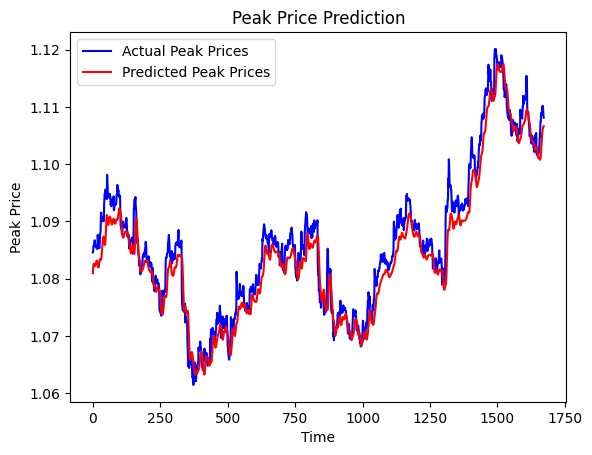

In [8]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Peak Prices')
plt.plot(predicted_prices_rescaled, color='red', label='Predicted Peak Prices')
plt.title('Peak Price Prediction')
plt.xlabel('Time')
plt.ylabel('Peak Price')
plt.legend()
plt.show()


In [9]:
model.save('../models/sept4.h5')

In [10]:
import plotly.graph_objects as go

# Example data
x = [1, 2, 3, 4, 5]
y = [10, 15, 13, 17, 14]

# Create the figure
fig = go.Figure()

# Add a line plot trace
fig.add_trace(go.Scatter(x=pd.DataFrame(y_test_rescaled).index, y=pd.DataFrame(y_test_rescaled)[0], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=pd.DataFrame(predicted_prices_rescaled).index, y=pd.DataFrame(predicted_prices_rescaled)[0], mode='lines', name='Predicted'))

# Update the layout with title and axis labels
fig.update_layout(
    title='Basic Line Plot',
    xaxis_title='X Axis',
    yaxis_title='Y Axis'
)

# Show the figure
fig.show()


In [11]:
y_test_rescaled

array([[1.08459],
       [1.08466],
       [1.08541],
       ...,
       [1.10917],
       [1.10857],
       [1.10812]])

In [12]:
predicted_prices_rescaled

array([[1.0809584],
       [1.0816494],
       [1.0821954],
       ...,
       [1.1064503],
       [1.1065544],
       [1.1066239]], dtype=float32)

In [13]:
dff = pd.DataFrame(y_test_rescaled)

In [15]:
dff[1]=predicted_prices_rescaled

In [16]:
dff

,0,1
0,1.08459,1.080958
1,1.08466,1.081649
2,1.08541,1.082195
3,1.08580,1.082510
4,1.08569,1.082597
...,...,...
1668,1.10933,1.106061
1669,1.11016,1.106301
1670,1.10917,1.106450
1671,1.10857,1.106554
